In [1]:
from dataset import Dataset
from feature_extractor import *
from feature_extractor import FeatureExtractor
from monitors import GaussianMixtureMonitor, Doctor
from monitors import *
from evaluation import Evaluator
import torch
from models import resnet
import pandas as pd
 
import os
import csv

In [2]:
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

In [3]:
batch_size = 10
device_name = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
all_id_datasets = ["cifar10", "svhn", "cifar100"]

all_ood_datasets = [["cifar100", "svhn", "lsun"],
                    ["cifar10", "tiny_imagenet", "lsun"],
                    ["cifar10", "svhn", "lsun"]]


all_perturbations = ["brightness", "blur", "pixelization"]

all_attacks = ["fgsm", "deepfool", "pgd"]


react_clip = [0.8, 0.9, 0.95, 0.99]
monitor_temperature = [1, 50, 75, 100]


alpha = [2, 3, 4, 6]

all_models = ["resnet", "densenet"]

all_layers_ids = [[32], [98]]

cv = 5




In [5]:
auroc_values_energy = []
auroc_values_react = []

aupr_values_energy = []
aupr_values_react = []

tnr95tpr_values_energy = []
tnr95tpr_values_react = []

In [6]:

for h in range(len(all_models)):
    model = all_models[h]
    for layer in all_layers_ids[h]:
        for n in range(len(all_id_datasets)):
            id_dataset = all_id_datasets[n]
            for i in range(len(all_ood_datasets[n])):
                ood_dataset = all_ood_datasets[n][i]

                dataset_train = Dataset(id_dataset, "train", model, batch_size=batch_size)
                dataset_test = Dataset(id_dataset, "test", model, batch_size=batch_size)
                dataset_ood = Dataset(ood_dataset, "test", model, None, None, batch_size=batch_size)

                feature_extractor = FeatureExtractor(model, id_dataset, [layer], device_name)
                features_train, logits_train, softmax_train, pred_train, lab_train = feature_extractor.get_features(dataset_train)
                features_test, logits_test, softmax_test, pred_test, lab_test = feature_extractor.get_features(dataset_test)
                features_ood, logits_ood, softmax_ood, pred_ood, lab_ood = feature_extractor.get_features(dataset_ood)

                eval_oms = Evaluator("oms", is_novelty=(id_dataset != ood_dataset))
                eval_oms.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)


                 # Moniteur EnergyMonitor
                monitor_energy = EnergyMonitor(temperature=1)
                monitor_energy.fit()

                scores_test_energy = monitor_energy.predict(logits_test)
                scores_ood_energy = monitor_energy.predict(logits_ood)

                aupr_energy = eval_oms.get_average_precision(scores_test_energy, scores_ood_energy)
                auroc_energy = eval_oms.get_auroc(scores_test_energy, scores_ood_energy)
                tnr95tpr_energy = eval_oms.get_tnr_frac_tpr_oms(scores_test_energy, scores_ood_energy, frac=0.95)

                # Moniteur ReActMonitor mode energy
                    
                monitor = ReActMonitor(quantile_value=0.99, mode = "energy")
                monitor.fit(feature_extractor, features_train[-1])

                scores_test = monitor.predict(features_test[-1])
                scores_ood = monitor.predict(features_ood[-1])

                aupr_react = eval_oms.get_average_precision(scores_test, scores_ood)
                auroc_react = eval_oms.get_auroc(scores_test, scores_ood)
                tnr95tpr_react = eval_oms.get_tnr_frac_tpr_oms(scores_test, scores_ood, frac=0.95)     



                auroc_values_energy.append(auroc_energy)
                auroc_values_react.append(auroc_react)

                aupr_values_energy.append(aupr_energy)
                aupr_values_react.append(aupr_react)

                tnr95tpr_values_energy.append(tnr95tpr_energy)
                tnr95tpr_values_react.append(tnr95tpr_react)




            for k in range(len(all_attacks)):
                ood_dataset = id_dataset

                adversarial_attack = all_attacks[k]


                dataset_train = Dataset(id_dataset, "train", model, batch_size=batch_size)
                dataset_test = Dataset(id_dataset, "test", model, batch_size=batch_size)
                dataset_ood = Dataset(id_dataset, "test", model, None, adversarial_attack, batch_size=batch_size)

                feature_extractor = FeatureExtractor(model, id_dataset, [layer], device_name)

                features_train, logits_train, softmax_train, \
                    pred_train, lab_train = feature_extractor.get_features(dataset_train)
                features_test, logits_test, softmax_test, \
                    pred_test, lab_test = feature_extractor.get_features(dataset_test)
                features_ood, logits_ood, softmax_ood, \
                    pred_ood, lab_ood = feature_extractor.get_features(dataset_ood)

                eval_oms = Evaluator("oms", is_novelty=(id_dataset != ood_dataset))
                eval_oms.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)


                 # Moniteur EnergyMonitor
                monitor_energy = EnergyMonitor(temperature=1)
                monitor_energy.fit()

                scores_test_energy = monitor_energy.predict(logits_test)
                scores_ood_energy = monitor_energy.predict(logits_ood)

                aupr_energy = eval_oms.get_average_precision(scores_test_energy, scores_ood_energy)
                auroc_energy = eval_oms.get_auroc(scores_test_energy, scores_ood_energy)
                tnr95tpr_energy = eval_oms.get_tnr_frac_tpr_oms(scores_test_energy, scores_ood_energy, frac=0.95)

                # Moniteur ReActMonitor mode energy
                    
                monitor = ReActMonitor(quantile_value=0.99, mode = "energy")
                monitor.fit(feature_extractor, features_train[-1])

                scores_test = monitor.predict(features_test[-1])
                scores_ood = monitor.predict(features_ood[-1])

                aupr_react = eval_oms.get_average_precision(scores_test, scores_ood)
                auroc_react = eval_oms.get_auroc(scores_test, scores_ood)
                tnr95tpr_react = eval_oms.get_tnr_frac_tpr_oms(scores_test, scores_ood, frac=0.95)     



                auroc_values_energy.append(auroc_energy)
                auroc_values_react.append(auroc_react)

                aupr_values_energy.append(aupr_energy)
                aupr_values_react.append(aupr_react)

                tnr95tpr_values_energy.append(tnr95tpr_energy)
                tnr95tpr_values_react.append(tnr95tpr_react)


            for j in range(len(all_perturbations)):
                ood_dataset = id_dataset

                additional_transform = all_perturbations[j]


                dataset_train = Dataset(id_dataset, "train", model, batch_size=batch_size)
                dataset_test = Dataset(id_dataset, "test", model, batch_size=batch_size)
                dataset_ood = Dataset(id_dataset, "test", model, additional_transform, None, batch_size=batch_size)

                feature_extractor = FeatureExtractor(model, id_dataset, [layer], device_name)

                features_train, logits_train, softmax_train, \
                    pred_train, lab_train = feature_extractor.get_features(dataset_train)
                features_test, logits_test, softmax_test, \
                    pred_test, lab_test = feature_extractor.get_features(dataset_test)
                features_ood, logits_ood, softmax_ood, \
                    pred_ood, lab_ood = feature_extractor.get_features(dataset_ood)

                eval_oms = Evaluator("oms", is_novelty=(id_dataset != ood_dataset))
                eval_oms.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)


                 # Moniteur EnergyMonitor
                monitor_energy = EnergyMonitor(temperature=1)
                monitor_energy.fit()

                scores_test_energy = monitor_energy.predict(logits_test)
                scores_ood_energy = monitor_energy.predict(logits_ood)

                aupr_energy = eval_oms.get_average_precision(scores_test_energy, scores_ood_energy)
                auroc_energy = eval_oms.get_auroc(scores_test_energy, scores_ood_energy)
                tnr95tpr_energy = eval_oms.get_tnr_frac_tpr_oms(scores_test_energy, scores_ood_energy, frac=0.95)

                # Moniteur ReActMonitor mode energy
                    
                monitor = ReActMonitor(quantile_value=0.99, mode = "energy")
                monitor.fit(feature_extractor, features_train[-1])

                scores_test = monitor.predict(features_test[-1])
                scores_ood = monitor.predict(features_ood[-1])

                aupr_react = eval_oms.get_average_precision(scores_test, scores_ood)
                auroc_react = eval_oms.get_auroc(scores_test, scores_ood)
                tnr95tpr_react = eval_oms.get_tnr_frac_tpr_oms(scores_test, scores_ood, frac=0.95)     



                auroc_values_energy.append(auroc_energy)
                auroc_values_react.append(auroc_react)

                aupr_values_energy.append(aupr_energy)
                aupr_values_react.append(aupr_react)

                tnr95tpr_values_energy.append(tnr95tpr_energy)
                tnr95tpr_values_react.append(tnr95tpr_react)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./Data/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and v

In [7]:
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
metrics_compare_colname = ['AUROC', 'AUPR', 'TNR95TPR']

res_statistic = np.zeros((1, len(metrics_compare_colname)))
res_pvalue = np.zeros((1, len(metrics_compare_colname)))
flag =  np.zeros((1, len(metrics_compare_colname))) 

p_value_list = []

In [9]:
from _plotting import _bron_kerbosch, _find_maximal_cliques, sign_plot, sign_table, sign_array
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from _plotting import *

In [10]:
def compute_average_ranks(list1, list2, pct=True):
    
    # Create a DataFrame with the combined data and indicator column
    data = pd.DataFrame({'Value': list1 + list2, 'Group': ['List 1'] * len(list1) + ['List 2'] * len(list2)})

    # Compute the average ranks using Pandas functions
    avg_rank = data.Value.rank(pct=pct).groupby(data.Group).mean()

    # Group by the original lists and calculate the mean of the average ranks
    avg_ranks_list1 = avg_rank[0]
    avg_ranks_list2 = avg_rank[1]

    return avg_ranks_list1, avg_ranks_list2

In [11]:
alpha = 0.05


wilcoxon_statistic_auroc, wilcoxon_pvalue_auroc = wilcoxon(auroc_values_energy, auroc_values_react, alternative='two-sided')
wilcoxon_statistic_aupr, wilcoxon_pvalue_aupr = wilcoxon(aupr_values_energy, aupr_values_react, alternative='two-sided')
wilcoxon_statistic_tnr95tpr, wilcoxon_pvalue_tnr95tpr = wilcoxon(tnr95tpr_values_energy, tnr95tpr_values_react, alternative='two-sided')


# Wilcoxon Test and analysis for AUROC

flag_auroc = np.zeros((1, 1))
if wilcoxon_pvalue_auroc <= alpha: #different distribution 
    avg_rank_groupA_auroc, avg_rank_groupB_auroc = compute_average_ranks(auroc_values_energy, auroc_values_react)

    if avg_rank_groupA_auroc > avg_rank_groupB_auroc:
        best_monitor = "ReAct Energy"
        flag_auroc[0, 0] = 1
    else:
        best_monitor = "Energy"
        flag_auroc[0, 0] = -1
else:
    best_monitor = "Equal"

    
print(f"Wilcoxon Test Results:")
print(f"Statistic: {wilcoxon_statistic_auroc}")
print(f"P-value: {wilcoxon_pvalue_auroc}")
if wilcoxon_pvalue_auroc <= alpha:
    print("Reject the null hypothesis. The distributions are different.")
else:
    print("Fail to reject the null hypothesis. The distributions are not significantly different.")
print(f"Best Monitor based on AUROC: {best_monitor}")


# Wilcoxon Test and analysis for AUPR

flag_aupr = np.zeros((1, 1))

if wilcoxon_pvalue_aupr <= alpha:
    avg_rank_groupA_aupr, avg_rank_groupB_aupr = compute_average_ranks(aupr_values_energy, aupr_values_react)

    if avg_rank_groupA_aupr > avg_rank_groupB_aupr:
        best_monitor_aupr = "ReAct Energy"
        flag_aupr[0, 0] = 1
    else:
        best_monitor_aupr = "Energy"
        flag_aupr[0, 0] = -1
else:
    best_monitor_aupr = "Equal"
    
    
    
print(f"Wilcoxon Test Results AUPR:")
print(f"Statistic: {wilcoxon_statistic_aupr}")
print(f"P-value: {wilcoxon_pvalue_aupr}")
if wilcoxon_pvalue_aupr <= alpha:
    print("Reject the null hypothesis. The distributions are different.")
else:
    print("Fail to reject the null hypothesis. The distributions are not significantly different.")
print(f"Best Monitor based on AUPR: {best_monitor}")

# Wilcoxon Test and analysis for TNR95TPR
flag_tnr95tpr = np.zeros((1, 1))

if wilcoxon_pvalue_tnr95tpr <= alpha:
    avg_rank_groupA_tnr95tpr, avg_rank_groupB_tnr95tpr = compute_average_ranks(tnr95tpr_values_energy , tnr95tpr_values_react)

    if avg_rank_groupA_tnr95tpr > avg_rank_groupB_tnr95tpr:
        best_monitor_tnr95tpr = "ReAct Energy"
        flag_tnr95tpr[0, 0] = 1
    else:
        best_monitor_tnr95tpr = "Energy"
        flag_tnr95tpr[0, 0] = -1
else:
    best_monitor_tnr95tpr = "Equal"

print(f"Wilcoxon Test Results TNR95TPR:")
print(f"Statistic: {wilcoxon_statistic_tnr95tpr}")
print(f"P-value: {wilcoxon_pvalue_tnr95tpr}")
if wilcoxon_pvalue_aupr <= alpha:
    print("Reject the null hypothesis. The distributions are different.")
else:
    print("Fail to reject the null hypothesis. The distributions are not significantly different.")
print(f"Best Monitor based on TNR95TPR: {best_monitor}")


Wilcoxon Test Results:
Statistic: 228.0
P-value: 9.425180990056328e-06
Reject the null hypothesis. The distributions are different.
Best Monitor based on AUROC: Energy
Wilcoxon Test Results AUPR:
Statistic: 248.0
P-value: 2.0649209689343985e-05
Reject the null hypothesis. The distributions are different.
Best Monitor based on AUPR: Energy
Wilcoxon Test Results TNR95TPR:
Statistic: 206.0
P-value: 3.84884772627368e-06
Reject the null hypothesis. The distributions are different.
Best Monitor based on TNR95TPR: Energy


In [12]:
labels = ['AUROC', 'AUPR', 'TNR95TPR']
wilcoxon_pvalues = [wilcoxon_pvalue_auroc, wilcoxon_pvalue_aupr, wilcoxon_pvalue_tnr95tpr]
flag_values = [flag_auroc[0, 0], flag_aupr[0, 0], flag_tnr95tpr[0, 0]]

res_pvalue = np.array([wilcoxon_pvalues])
flag = np.array([flag_values])

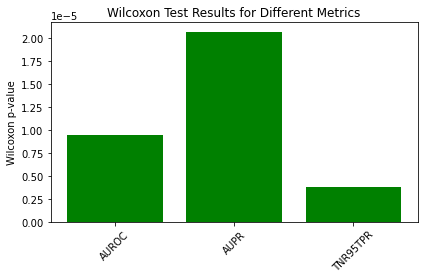

In [13]:
fig, ax = plt.subplots()
ax.bar(labels, wilcoxon_pvalues, color=['blue' if f == 1 else 'green' if f == -1 else 'gray' for f in flag_values])

ax.set_ylabel('Wilcoxon p-value')
ax.set_title('Wilcoxon Test Results for Different Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/home/njemmat/anaconda3/envs/neural-network-monitoring-benchmark/lib/python3.10/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/njemmat/anaconda3/envs/neural-network-monitoring-benchmark/lib/python3.10/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/tmp/ipykernel_25555/856248000.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


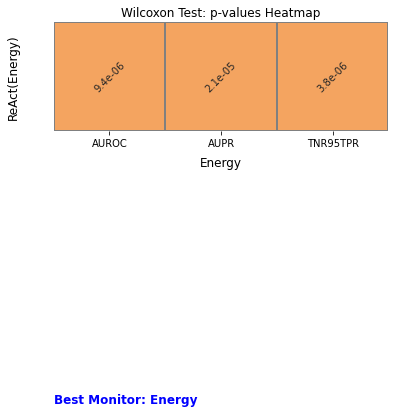

In [14]:
fig, ax = plt.subplots(figsize=(6, 2))
ax_plot = sns.heatmap(res_pvalue, annot=True, fmt='.1e', cbar=False, annot_kws={'rotation': 45}, 
                      xticklabels=labels, yticklabels=[],
                      cmap=ListedColormap(['white']), ax=ax)
ax_plot = sns.heatmap(res_pvalue, mask=(flag!=1), cbar=False, 
                      xticklabels=labels, yticklabels=[], cmap=ListedColormap(['green']), ax=ax)

ax_plot = sns.heatmap(res_pvalue, mask=(flag!=-1), cbar=False, linewidths=2, linecolor='gray',
                      xticklabels=labels, yticklabels=[], cmap=ListedColormap(['sandybrown']), ax=ax) 

best_monitor = "ReAct Energy" if flag_values[1] == 1 else "Energy"
ax.text(0, 3.5, f'Best Monitor: {best_monitor}', fontsize=12, color='blue', fontweight='bold')

ax.annotate('Energy', xy=(0.5, -0.25), xytext=(0.5, -0.35),  # Ajustez les valeurs xytext pour réduire la distance
            xycoords='axes fraction', textcoords='axes fraction', 
            fontsize=12,
            horizontalalignment='center', verticalalignment='bottom')
            
ax.annotate('ReAct(Energy)', xy=(-0.1, 0.5), xytext=(-0.1, 0.5),  # Ajustez les valeurs xytext pour réduire la distance
            xycoords='axes fraction', textcoords='axes fraction', 
            fontsize=12,
            horizontalalignment='right', verticalalignment='center', rotation=90)


ax.set_title('Wilcoxon Test: p-values Heatmap')
plt.tight_layout()

plt.show()